In [1]:
import glob
from skimage.io import imread, imsave
import skimage.draw
import matplotlib.pyplot as plt
import pandas as pd

from xml_to_dict import XMLtoDict

In [2]:
import os.path

if not os.path.isdir('data/stones/stone_1'):
    os.mkdir('data/stones/stone_1')

if not os.path.isdir('data/stones/stone_2'):
    os.mkdir('data/stones/stone_2')

for voc_file in glob.glob('data/labelled/*.xml'):
    jpg_file = voc_file.replace('.xml', '.jpg')
    img = imread(jpg_file)

    stones = [
        (stone['name'], {
            'x1': int(stone['bndbox']['xmin']),
            'y1': int(stone['bndbox']['ymin']),
            'x2': int(stone['bndbox']['xmax']),
            'y2': int(stone['bndbox']['ymax']),
        })
        for stone in XMLtoDict.parse(open(voc_file).read())['annotation']['object']
    ]
    # print(stones)
    for stone_name, stone_box in stones:
        width = stone_box['x2']-stone_box['x1']
        height = stone_box['y2']-stone_box['y1']
        stone_jpg = f"data/stones/{stone_name}/{jpg_file.split('/')[-1].replace('.jpg', '')}-w{'%03d' % width}-h{'%03d' % height}-{'%04d' % stone_box['x1']}-{'%04d' % stone_box['y1']}-{'%04d' % stone_box['x2']}-{'%04d' % stone_box['y2']}.jpg"
        if not os.path.isfile(stone_jpg):
            stone_img = skimage.util.crop(img, [
                (stone_box['y1'],len(img)-stone_box['y2']),
                (stone_box['x1'],len(img[0])-stone_box['x2']),
                (0,0)
            ], copy=True)
            # fig, ax = plt.subplots(figsize=(2, 2))
            # ax.axis("off")
            # ax.imshow(stone_img)
            # plt.show()
            imsave(stone_jpg, stone_img)  

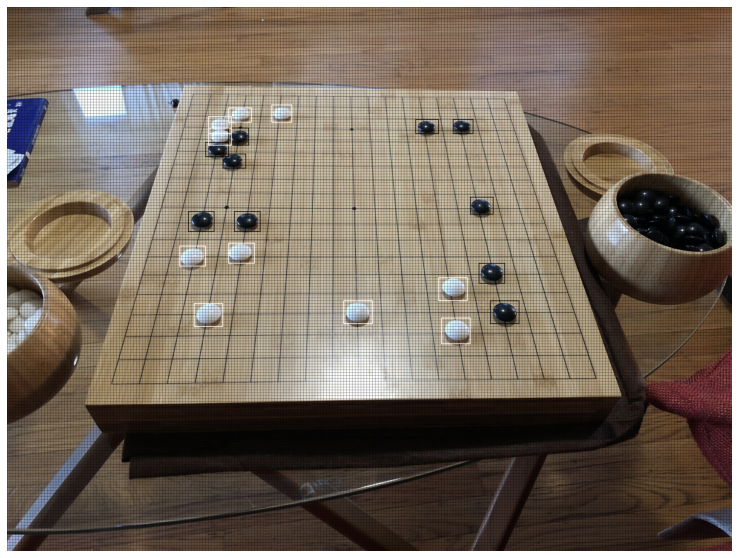

1280 720 skipping


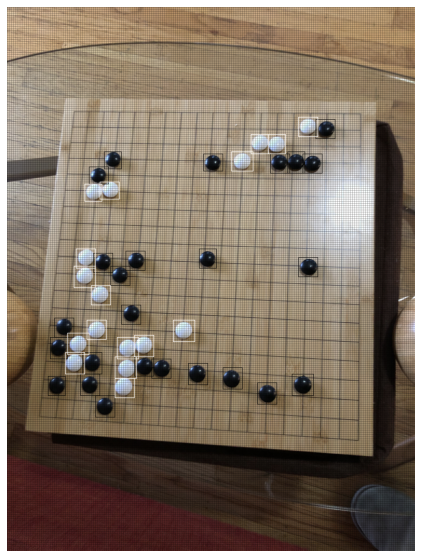

In [3]:

sizes = []
for voc_file in glob.glob('data/labelled/*.xml'):
    jpg_file = voc_file.replace('.xml', '.jpg')
    img = imread(jpg_file)
    if len(img) < 1000:
        print(len(img[0]), len(img), 'skipping')
        continue
        
    stones = [
        (stone['name'], {
            'x1': int(stone['bndbox']['xmin']),
            'y1': int(stone['bndbox']['ymin']),
            'x2': int(stone['bndbox']['xmax']),
            'y2': int(stone['bndbox']['ymax']),
        })
        for stone in XMLtoDict.parse(open(voc_file).read())['annotation']['object']
    ]

    step_size = 16
    for x in range(0, len(img[0]), step_size):
        rr, cc = skimage.draw.line(0, x, len(img)-1, x)
        # print(rr, cc)
        img[rr, cc, :] = 0

    for y in range(0, len(img), step_size):
        rr, cc = skimage.draw.line(y, 0, y, len(img[0])-1)
        img[rr, cc, :] = 0

    for stone_name, stone_box in stones:
        for border in range(0,4):
            x1 = stone_box['x1']
            y1 = stone_box['y1']
            x2 = stone_box['x2']
            y2 = stone_box['y2']

            x1 = x1 - (x1 % step_size)
            y1 = y1 - (y1 % step_size)

            x2 = x2 + (step_size - (x2 % step_size))
            y2 = y2 + (step_size - (y2 % step_size))

            step_width = (x2-x1)/step_size
            step_height = (y2-y1)/step_size
            sizes.append({'width': step_width, 'height': step_height})

            rr, cc = skimage.draw.rectangle_perimeter(start=(y1+border, x1+border), end=(y2-border, x2-border))
            img[rr, cc, :] = (0 if stone_name == 'stone_1' else 255)
   
    fig, ax = plt.subplots(figsize=(18, 10))
    ax.axis("off")
    ax.imshow(img)
    plt.show()

In [4]:
print('Dimensions frequency data')
df = pd.DataFrame(sizes).astype(int)
df['area'] = df['width'] * df['height']
df['dimensions'] = df.apply(lambda row: f"{row['width']} x {row['height']}", axis=1)
display(pd.DataFrame({'frequency':df.groupby(['area', 'dimensions']).size()}).reset_index().sort_values('area').set_index('dimensions')[['frequency']])

Dimensions frequency data


,frequency
dimensions,
7 x 5,4
8 x 5,16
7 x 6,8
8 x 6,12
9 x 7,20
8 x 8,8
8 x 9,16
9 x 8,12
10 x 8,16
